In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qq transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data_preprocess.csv')
df.head()

,time,text,processed_text,textblob_score,textblob_label,VADER_score,VADER_label,combined_score,label,split
0,2024-07-22 23:50:08,"On Qingdao Zhongshan Road, a silver-gray drive...",qingdao zhongshan road silvergray driverless c...,-0.050000,neutral,0.0000,neutral,-0.025000,neutral,test
1,2024-07-22 23:49:54,"On Qingdao Zhongshan Road, a silver-gray drive...",qingdao zhongshan road silvergray driverless c...,-0.050000,neutral,0.0000,neutral,-0.025000,neutral,train
2,2024-07-22 23:44:34,"@elonmusk Brother Ma, does your Tesla driverle...",brother tesla driverless car support core paym...,0.000000,neutral,0.4019,positive,0.200950,positive,train
3,2024-07-22 21:06:00,"@visualfeastwang Wow, Driverless car_ China is...",wow driverless car china work next level aur y...,0.050000,neutral,0.8126,positive,0.431300,positive,train
4,2024-07-22 21:04:25,"@Kling_ai Translation: In 2028, the driverless...",translation driverless car enter united state ...,0.104167,positive,0.0258,neutral,0.064983,neutral,train


In [5]:
df.shape

(45713, 10)

In [6]:
class_names = df['label'].unique().tolist()
print(class_names)

['neutral', 'positive', 'negative']


In [7]:
import re

def remove_urls(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return url_pattern.sub(r'', text)

def remove_hashtagsandmentions(text):
    hashtagsandmentions_pattern = re.compile(r'@\w+|#\w+')
    return hashtagsandmentions_pattern.sub(r'', text)

def add_spaces_around_special_chars(text):
    text = re.sub(r"([!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~])", r' \1 ', text)
    return re.sub(r'\s{2,}', ' ', text)


In [8]:
df['text'] = df['text'].apply(lambda x: remove_urls(x))
df['text'] = df['text'].apply(lambda x: remove_hashtagsandmentions(x))
df['text'] = df['text'].apply(lambda x: add_spaces_around_special_chars(x))

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

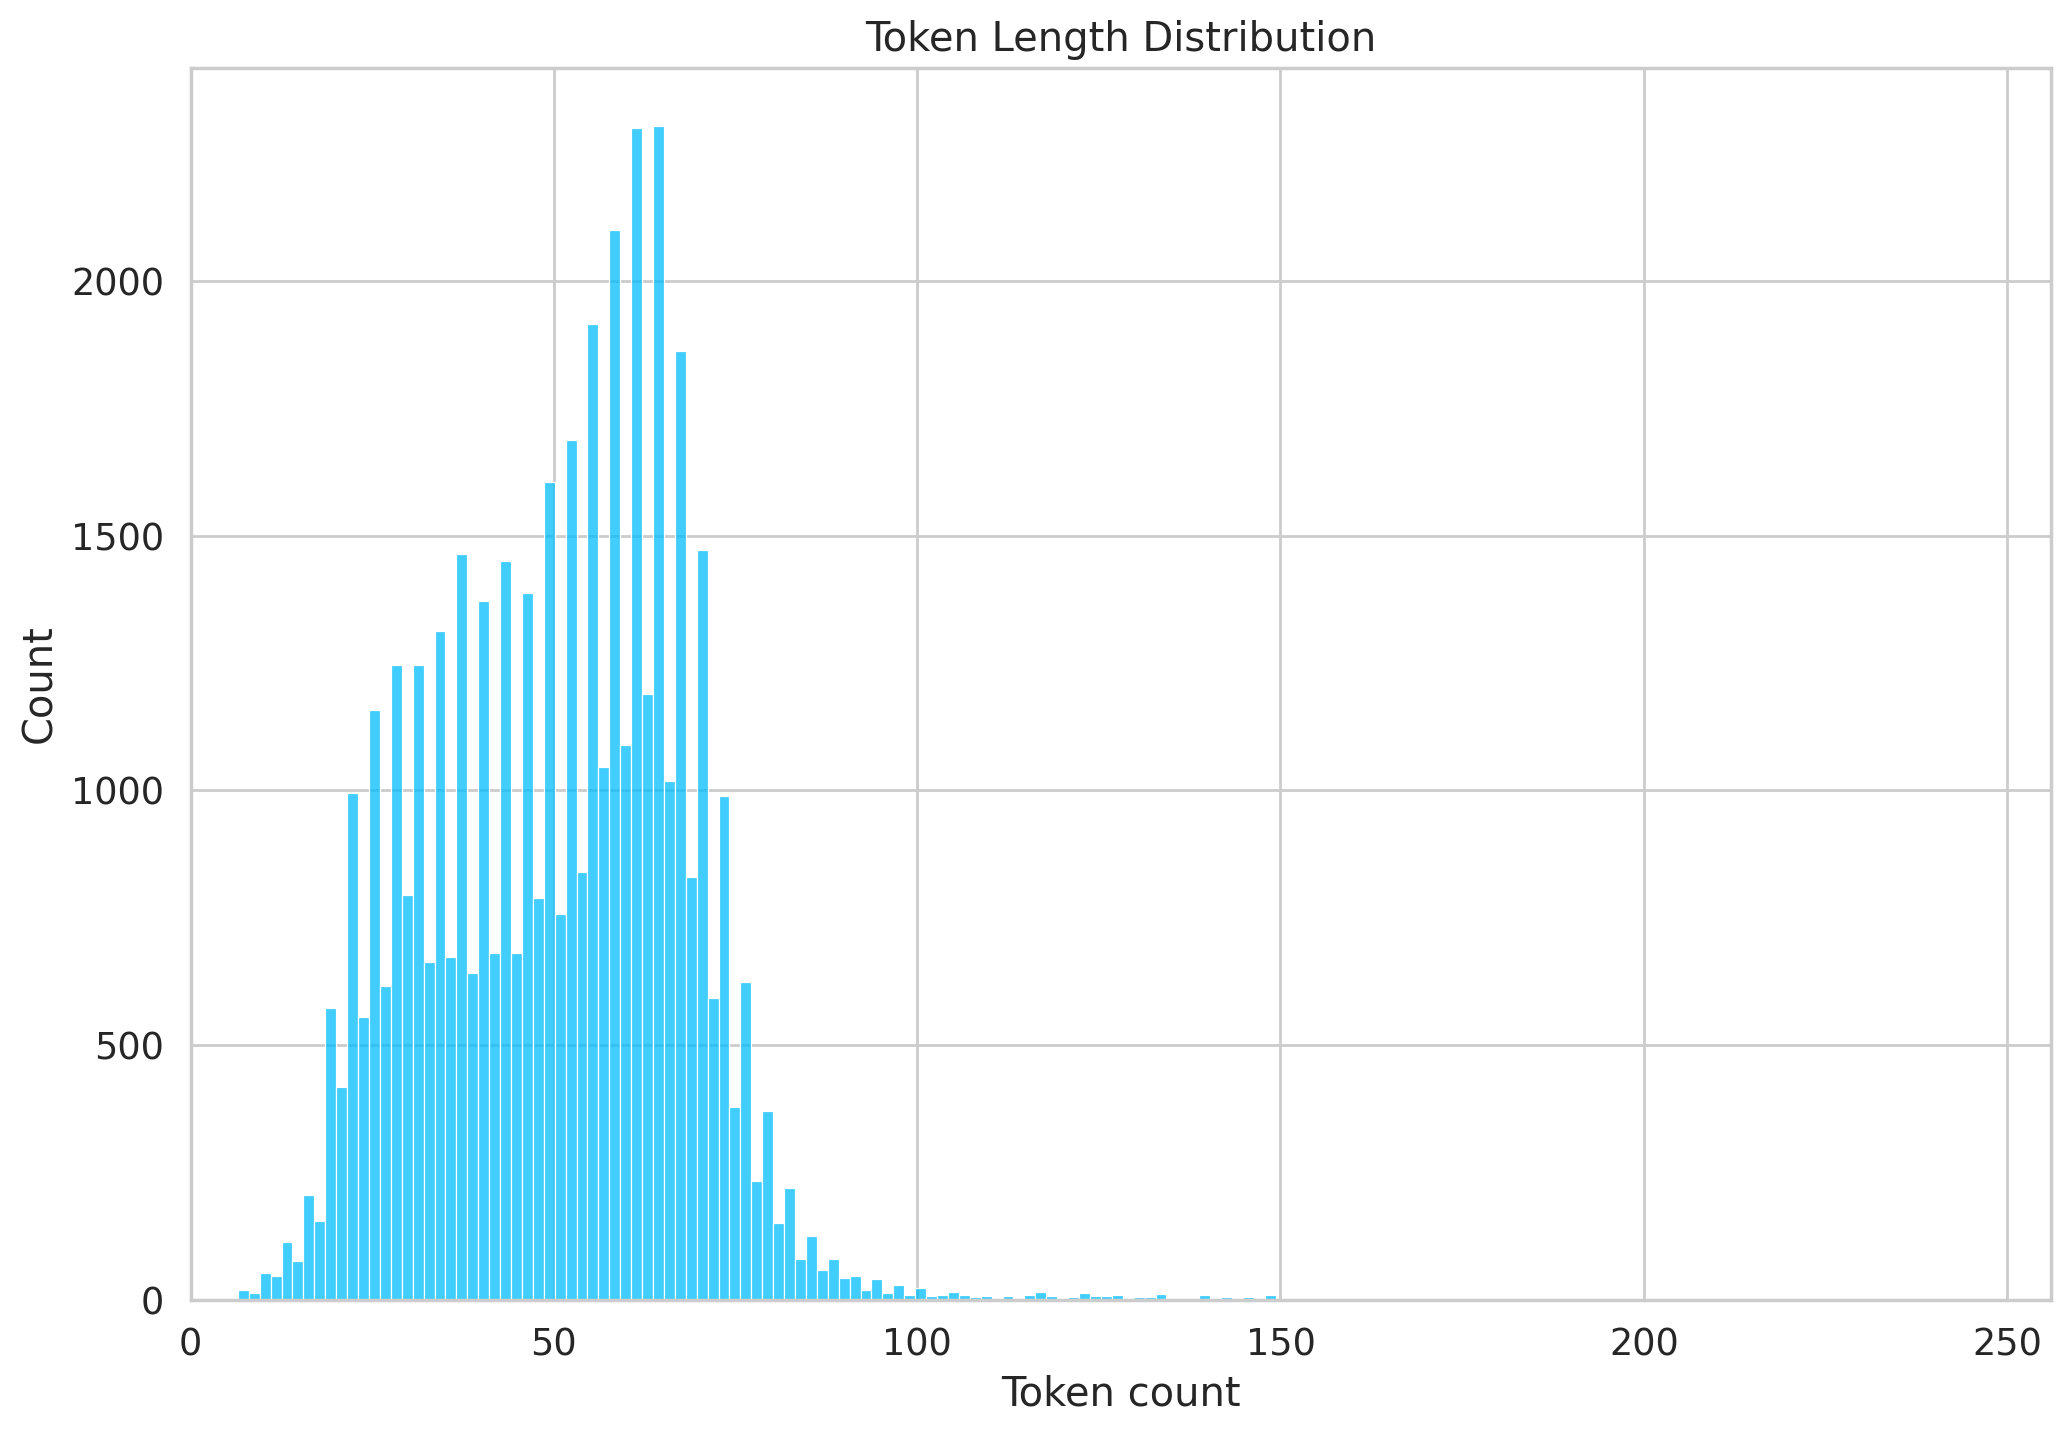

In [10]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.title('Token Length Distribution')
plt.show()

In [11]:
max(token_lens)

217

In [12]:
sum(1 for length in token_lens if length > 150)

5

In [13]:
MAX_LEN = 150

In [14]:
class TweetDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        review = review.lower()
        target = self.targets[item]

        target_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        target = target_map[target]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }



In [15]:
df_train = df[df.split == "train"]
df_val = df[df.split == "val"]
df_test = df[df.split == "test"]

In [16]:
df_train.shape, df_val.shape, df_test.shape

((31999, 10), (6857, 10), (6857, 10))

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        reviews=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

In [18]:
BATCH_SIZE = 128

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [20]:
class TweetClassifier(nn.Module):
    def __init__(self, n_classes):
        super(TweetClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(outputs.pooler_output)
        return self.out(output)

In [21]:
n_classes = 3
model = TweetClassifier(n_classes)
model = model.to(device)

In [22]:
EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [23]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.cpu().detach().numpy())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu().detach().numpy())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7326035567522049 accuracy 0.6843651364105128
Val   loss 0.5208737077536406 accuracy 0.7923290068543095

Epoch 2/10
----------
Train loss 0.47928261864185334 accuracy 0.8098690584080752
Val   loss 0.47342511845959556 accuracy 0.8143502989645618

Epoch 3/10
----------
Train loss 0.3622403372526169 accuracy 0.8591518484952655
Val   loss 0.4408523103705159 accuracy 0.8293714452384425

Epoch 4/10
----------
Train loss 0.2825851925313473 accuracy 0.8930279071220976
Val   loss 0.43790695788683714 accuracy 0.8363715910748141

Epoch 5/10
----------
Train loss 0.22349195852875708 accuracy 0.9179349354667333
Val   loss 0.4644999236420349 accuracy 0.8388508093918624

Epoch 6/10
----------
Train loss 0.1744458114504814 accuracy 0.9388105878308697
Val   loss 0.5060246868266 accuracy 0.8330173545282193

Epoch 7/10
----------
Train loss 0.14420807127654553 accuracy 0.951092221631926
Val   loss 0.5511655426687665 accuracy 0.8373924456759516

Epoch 8/10
----------
Trai

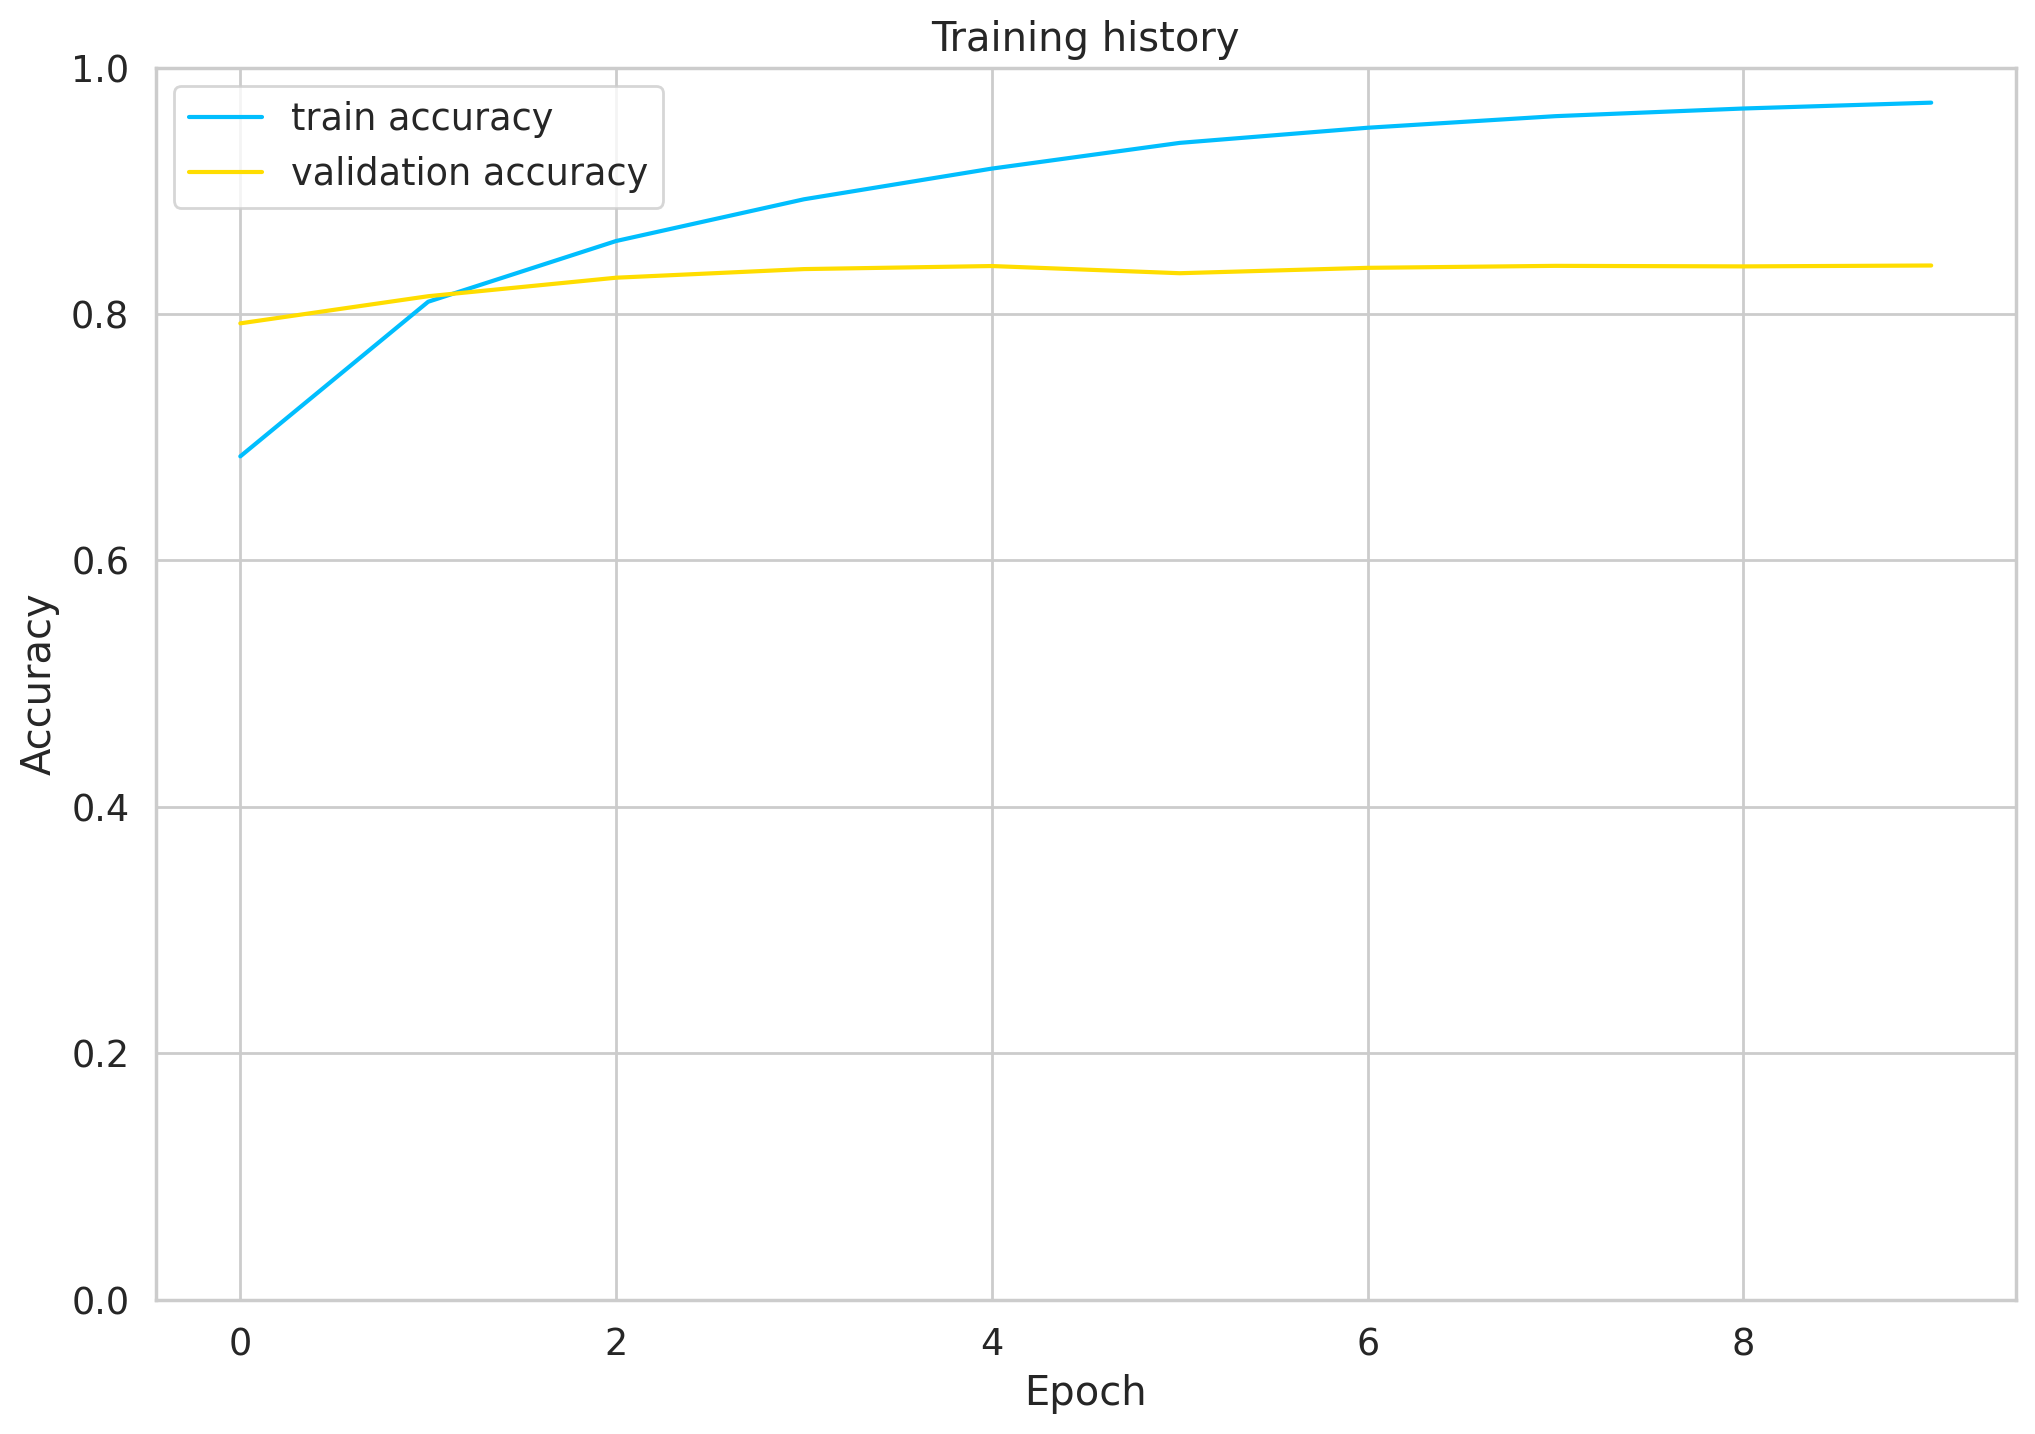

In [26]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [27]:
model.load_state_dict(torch.load('best_model_state.bin', weights_only=False)) # Load the best model
model = model.to(device)

test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item(), test_loss.item()

(0.8223712994020709, 0.6966416002423675)

In [28]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [29]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [30]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.87      0.87      0.87      2301
    positive       0.63      0.65      0.64      1508
    negative       0.89      0.87      0.88      3048

    accuracy                           0.82      6857
   macro avg       0.79      0.80      0.80      6857
weighted avg       0.82      0.82      0.82      6857



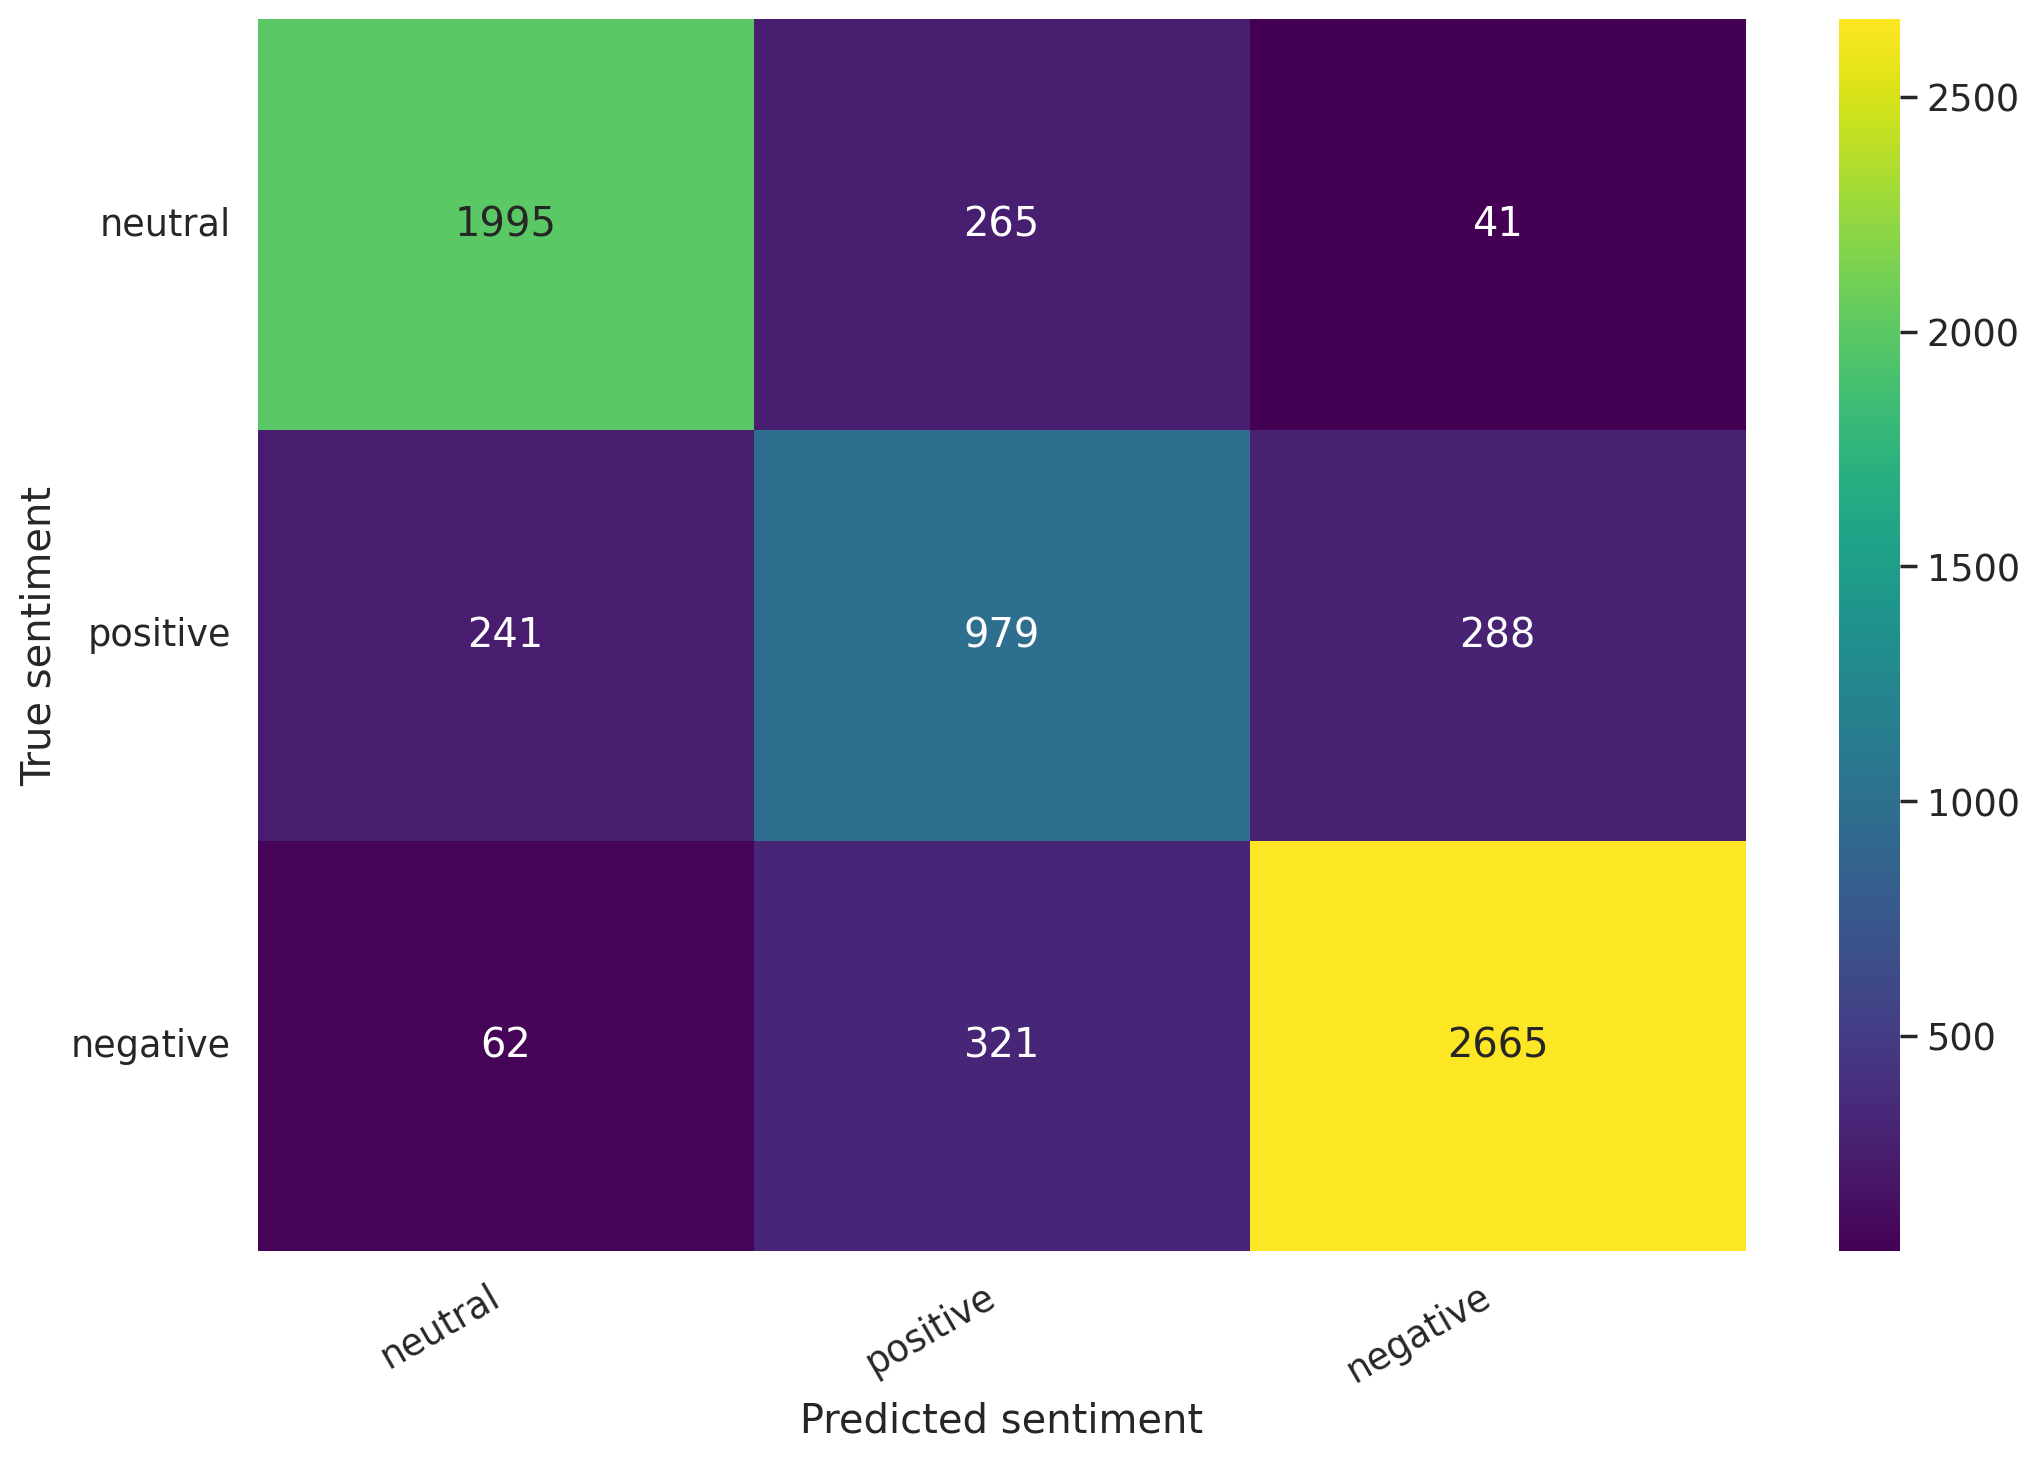

In [31]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="viridis")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)